In [ ]:
import pandas as pd                 # DB 분석 위한 핵심 라이브러리 -> DataFrame, Series 등 DB 구조 제공
import numpy as np                  # 수치 연산 위한 핵심 라이브러리 -> 수치 계산, 배열 연산
import matplotlib.pyplot as plt     # 시각화 위한 핵심 라이브러리 -> 그래프, 차트 그리기
import seaborn as sns               # 시각화 위한 핵심 라이브러리 -> matplolib 기반 고급 통계 시각화 라이브러리
from scipy import stats             # 통계 연산 위한 핵심 라이브러리 -> 통계 분석, 확률 분포 관련 함수들 제공
import warnings                     # 경고 메세지 제어
warnings.filterwarnings('ignore')   # 경고 메세지 무시

# 한글 폰트 설정
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist if 'Gothic' in font.name or 'Malgun' in font.name]
if font_list:
    plt.rcParams['font.family'] = font_list[0]
else:
    # 대안 폰트들
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except:
        try:
            plt.rcParams['font.family'] = 'Microsoft YaHei'
        except:
            plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['axes.unicode_minus'] = False   # 마이너스 표시 위한 설정

print("=== 📚 라이브러리 로딩 완료 ===")

In [ ]:
# 데이터 로딩 (자기 파일 위치로 바꿔서 하세요)
df = pd.read_csv(r'C:\Users\jueun\Desktop\Uni\기후빅데이터\CLIMAX\train_subway_2021.csv', encoding='utf-8')

print("=== 🔍 초기 데이터 확인 ===")
print(f"📊 데이터 shape: {df.shape}")       # dataframe의 크기(행, 열 수) 출력 -> f-string 사용하여 변수 값을 문자열에 삽입
print(f"📋 컬럼명: {df.columns.tolist()}")  # dataframe의 컬럼명 리스트 형태로 출력

# dataframe의 전체적인 정보 출력 (각 컬럼의 데이터 타입, 결측치 개수, 메모리 사용량 등)
print("\n📈 기본 정보:")
df.info()

# 데이터의 상위 5행 섹션 제목 출력
print("\n📄 상위 5행:")
print(df.head())

# 결측치 처리 (-99를 NaN으로 변환)
print("\n🚨 결측치 처리 중...")
weather_cols = ['ta', 'wd', 'ws', 'rn_day', 'hm']
for col in weather_cols:
    before_count = (df[col] == -99).sum()
    df[col] = df[col].replace(-99, np.nan)
    print(f"{col}: -99 값 {before_count:,}개를 NaN으로 변환")

# 시간 변수 추출
## 현재 tm 컬럼은 년월일시간이 합쳐진 상태임. -> 시간대별 분석이 필요하기 때문에 시간 변수 추출
df['m_hr1'] = df['tm'] % 100

print(f"\n⏰ 시간 변수 추출 확인:")
print(f"tm 샘플: {df['tm'].head().tolist()}")
print(f"추출된 시간 범위: {df['m_hr1'].min()} ~ {df['m_hr1'].max()}")
print(df['m_hr1'].value_counts().sort_index())
print(f"시간 분포 (상위 10개):")
print(df['m_hr1'].value_counts().sort_index().head(10))

# 변수들 대한 기술통계(평균, 표준편차, 최솟값, 최댓값 등)
print("\n📊 기본 통계:")
print(df[weather_cols + ['congestion', 'm_hr1']].describe())

# 혼잡도 관련 범위, 평균, 결측치 확인
print("\n🎯 타겟 변수 확인:")
target_col = 'congestion'
print(f"혼잡도 범위: {df[target_col].min():.2f} ~ {df[target_col].max():.2f}")
print(f"혼잡도 평균: {df[target_col].mean():.2f}")
print(f"혼잡도 결측치: {df[target_col].isnull().sum()}개")

# 날씨 변수 관련 범위 및 결측치 수
print("\n🌡️ 날씨 변수 확인:")
for col in weather_cols:
    non_null_data = df[col].dropna()
    if len(non_null_data) > 0:
        print(f"{col}: {non_null_data.min():.2f} ~ {non_null_data.max():.2f} (결측치: {df[col].isnull().sum():,}개)")
    else:
        print(f"{col}: 모든 값이 결측치")

print(f"\n📊 최종 데이터 현황:")
print(f"전체 행 수: {len(df):,}")
print(f"결측치가 없는 완전한 행 수: {len(df.dropna()):,}")

In [ ]:
print("=== 🌡️ 기온 × 시간대 상호작용 분석 ===")

# 기온 구간 생성
df['temp_category'] = pd.cut(df['ta'], bins=3, labels=['저온', '중온', '고온'])

print("📊 기온 구간 생성 확인:")
print(df['temp_category'].value_counts())
print(f"\n기온 구간별 실제 온도 범위:")
temp_ranges = df.groupby('temp_category')['ta'].agg(['min', 'max', 'mean'])
print(temp_ranges)

print("\n📄 기온과 구간 매핑 확인:")
print(df[['ta', 'temp_category']].head(10))

# 결측치가 있는 행 제외하고 상호작용 분석
interaction_temp_hour = df.dropna(subset=['ta', 'temp_category']).groupby(['m_hr1', 'temp_category'])['congestion'].mean().unstack()

print(f"\n📊 그룹화 결과 확인:")
print(f"그룹화 후 shape: {interaction_temp_hour.shape}")
print("\n상호작용 테이블:")
print(interaction_temp_hour.round(3))

# 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(interaction_temp_hour.T, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': '평균 혼잡도'})
plt.title('기온 구간별 × 시간대별 평균 혼잡도', fontsize=16, pad=20)
plt.xlabel('시간대', fontsize=12)
plt.ylabel('기온 구간', fontsize=12)
plt.tight_layout()
plt.show()

# 패턴 분석
print("\n🔍 패턴 분석:")
for temp_cat in interaction_temp_hour.columns:
    peak_hour = interaction_temp_hour[temp_cat].idxmax()
    peak_value = interaction_temp_hour[temp_cat].max()
    min_hour = interaction_temp_hour[temp_cat].idxmin()
    min_value = interaction_temp_hour[temp_cat].min()
    print(f"{temp_cat}: 피크 {peak_hour}시({peak_value:.2f}), 최저 {min_hour}시({min_value:.2f})")

=== 🌧️ 강수 × 요일 상호작용 분석 ===
📊 강수 데이터 결측치 확인:
rn_day 결측치: 119,472개
전체 데이터 대비 결측치 비율: 2.19%

📈 강수량 기본 통계:
count    5.332671e+06
mean     1.520380e+00
std      6.196885e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.045000e+02
Name: rn_day, dtype: float64

강수 발생일 수: 1,016,125일
강수 발생 비율: 19.05%

🌧️ 강수량 세분화 결과:
rain_intensity
무강수    4316546
약한비     633738
보통비     267499
NaN     119472
강한비     114888
Name: count, dtype: int64

각 카테고리별 비율:
무강수: 4,316,546개 (79.17%)
약한비: 633,738개 (11.62%)
보통비: 267,499개 (4.91%)
결측치: 119,472개 (2.19%)
강한비: 114,888개 (2.11%)

📅 날짜에서 요일 추출 중...

🧹 결측치 처리:
처리 전 데이터 수: 5,452,143개
rain_intensity 결측치: 119,472개
weekday_name 결측치: 0개
congestion 결측치: 0개
처리 후 데이터 수: 5,332,671개
제거된 데이터: 119,472개 (2.19%)

📊 강수량 세분화 × 요일별 상호작용 분석:
평균 혼잡도 및 데이터 수:
                              mean   count
weekday_name rain_intensity               
월요일          무강수             19.35  594714
             약한비             19.99  112872
         

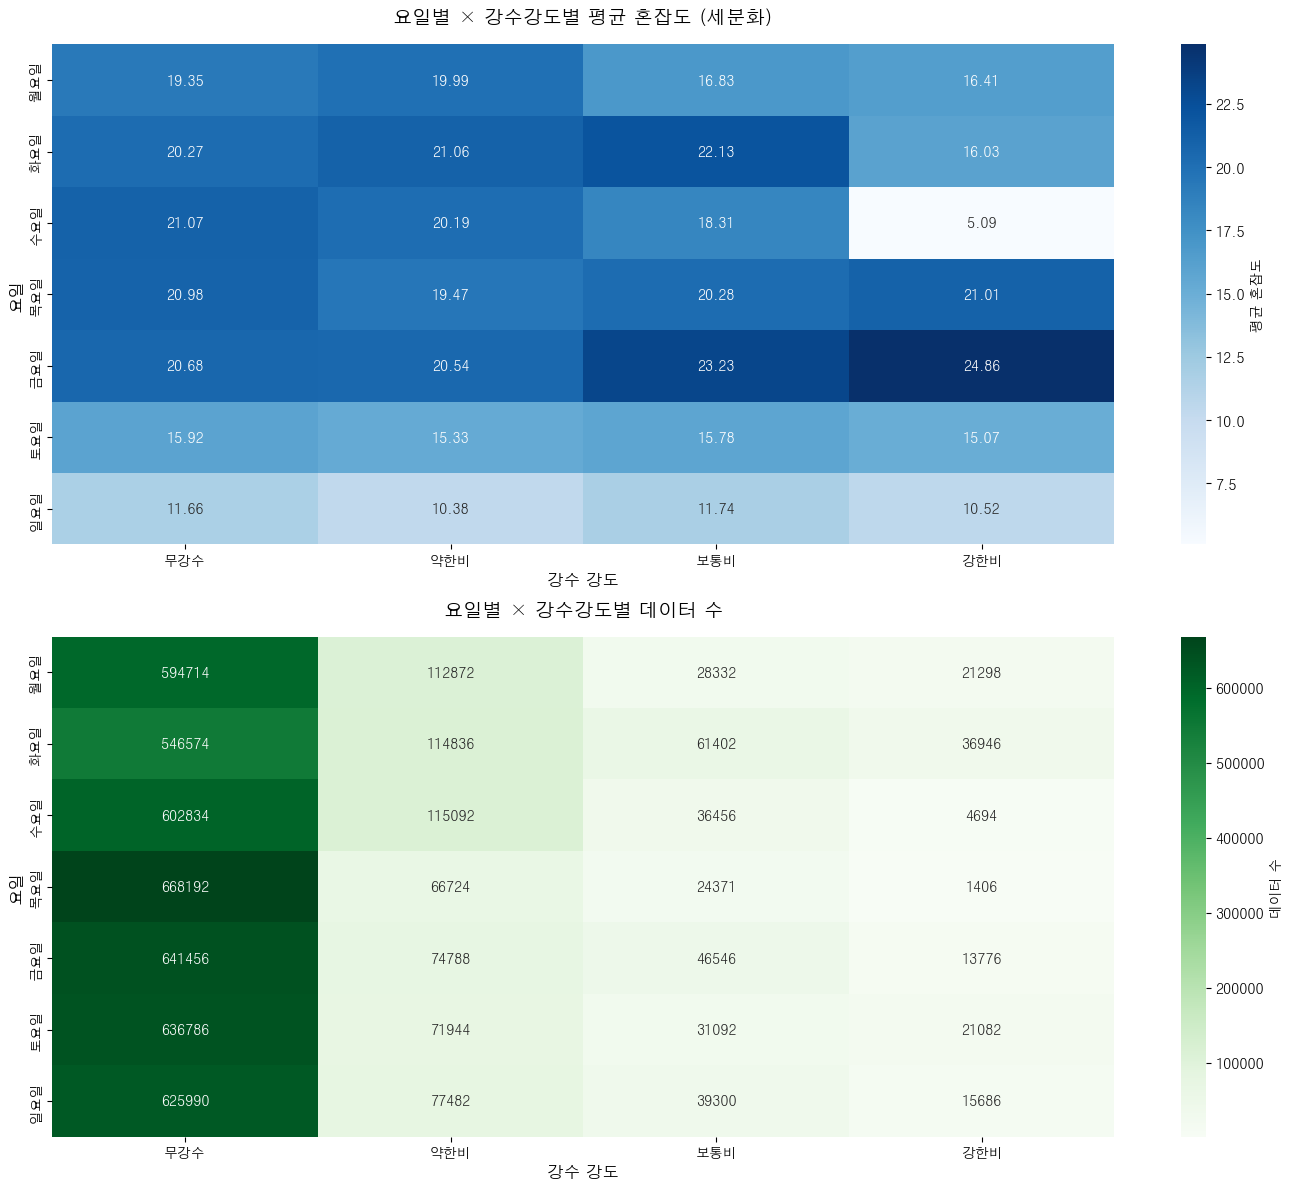


🔍 상세 패턴 분석:

📅 월요일:
  무강수: 19.35 (데이터 수: 594,714개)
  약한비: 19.99 (데이터 수: 112,872개)
  보통비: 16.83 (데이터 수: 28,332개)
  강한비: 16.41 (데이터 수: 21,298개)
  📊 무강수 대비 변화량:
    약한비: +0.64 (+3.3%)
    보통비: -2.52 (-13.0%)
    강한비: -2.93 (-15.2%)

📅 화요일:
  무강수: 20.27 (데이터 수: 546,574개)
  약한비: 21.06 (데이터 수: 114,836개)
  보통비: 22.13 (데이터 수: 61,402개)
  강한비: 16.03 (데이터 수: 36,946개)
  📊 무강수 대비 변화량:
    약한비: +0.79 (+3.9%)
    보통비: +1.86 (+9.2%)
    강한비: -4.25 (-20.9%)

📅 수요일:
  무강수: 21.07 (데이터 수: 602,834개)
  약한비: 20.19 (데이터 수: 115,092개)
  보통비: 18.31 (데이터 수: 36,456개)
  강한비: 5.09 (데이터 수: 4,694개)
  📊 무강수 대비 변화량:
    약한비: -0.88 (-4.2%)
    보통비: -2.76 (-13.1%)
    강한비: -15.99 (-75.9%)

📅 목요일:
  무강수: 20.98 (데이터 수: 668,192개)
  약한비: 19.47 (데이터 수: 66,724개)
  보통비: 20.28 (데이터 수: 24,371개)
  강한비: 21.01 (데이터 수: 1,406개)
  📊 무강수 대비 변화량:
    약한비: -1.51 (-7.2%)
    보통비: -0.70 (-3.4%)
    강한비: +0.03 (+0.1%)

📅 금요일:
  무강수: 20.68 (데이터 수: 641,456개)
  약한비: 20.54 (데이터 수: 74,788개)
  보통비: 23.23 (데이터 수: 46,546개)
  강한비: 24.86 (데이터 수: 13,77

In [12]:
print("=== 🌧️ 강수 × 요일 상호작용 분석 ===")

# 결측치 처리 강화
print("📊 강수 데이터 결측치 확인:")
print(f"rn_day 결측치: {df['rn_day'].isnull().sum():,}개")
print(f"전체 데이터 대비 결측치 비율: {df['rn_day'].isnull().sum() / len(df) * 100:.2f}%")

# 강수량 분포 확인
print(f"\n📈 강수량 기본 통계:")
print(df['rn_day'].describe())
print(f"\n강수 발생일 수: {(df['rn_day'] > 0).sum():,}일")
print(f"강수 발생 비율: {(df['rn_day'] > 0).sum() / df['rn_day'].notna().sum() * 100:.2f}%")

# 강수량 세분화 함수 정의
def categorize_rain(rain_amount):
    """
    강수량을 4단계로 세분화하는 함수
    - 무강수: 0mm
    - 약한비: 0.1~5mm
    - 보통비: 5.1~20mm  
    - 강한비: 20mm 초과
    """
    if pd.isna(rain_amount):
        return np.nan
    elif rain_amount == 0:
        return '무강수'
    elif rain_amount <= 5:
        return '약한비'
    elif rain_amount <= 20:
        return '보통비'
    else:
        return '강한비'

# 강수량 카테고리 생성
df['rain_intensity'] = df['rn_day'].apply(categorize_rain)
rain_order = ['무강수', '약한비', '보통비', '강한비']
df['rain_intensity'] = pd.Categorical(df['rain_intensity'], categories=rain_order, ordered=True)

print(f"\n🌧️ 강수량 세분화 결과:")
rain_counts = df['rain_intensity'].value_counts(dropna=False)
print(rain_counts)
print(f"\n각 카테고리별 비율:")
for category, count in rain_counts.items():
    if pd.isna(category):
        print(f"결측치: {count:,}개 ({count/len(df)*100:.2f}%)")
    else:
        print(f"{category}: {count:,}개 ({count/len(df)*100:.2f}%)")

# 날짜에서 요일 추출
print("\n📅 날짜에서 요일 추출 중...")
df['date'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
df['weekday'] = df['date'].dt.dayofweek  # 월요일=0, 일요일=6
df['weekday_name'] = df['date'].dt.day_name().map({
    'Monday': '월요일',
    'Tuesday': '화요일', 
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
})

weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
df['weekday_name'] = pd.Categorical(df['weekday_name'], categories=weekday_order, ordered=True)

# 결측치 제거한 클린 데이터셋 생성
print(f"\n🧹 결측치 처리:")
print(f"처리 전 데이터 수: {len(df):,}개")

# 분석에 필요한 컬럼들의 결측치 확인
analysis_cols = ['rain_intensity', 'weekday_name', 'congestion']
for col in analysis_cols:
    missing_count = df[col].isnull().sum()
    print(f"{col} 결측치: {missing_count:,}개")

# 결측치가 없는 데이터만 선택
df_clean = df.dropna(subset=['rain_intensity', 'weekday_name', 'congestion']).copy()
df_clean['rain_intensity'] = pd.Categorical(df_clean['rain_intensity'], categories=rain_order, ordered=True)
df_clean['weekday_name'] = pd.Categorical(df_clean['weekday_name'], categories=weekday_order, ordered=True)
print(f"처리 후 데이터 수: {len(df_clean):,}개")
print(f"제거된 데이터: {len(df) - len(df_clean):,}개 ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

# 상호작용 분석 (세분화된 강수량 기준)
print(f"\n📊 강수량 세분화 × 요일별 상호작용 분석:")
interaction_detailed = df_clean.groupby(['weekday_name', 'rain_intensity'])['congestion'].agg(['mean', 'count']).round(2)
print("평균 혼잡도 및 데이터 수:")
print(interaction_detailed)

# 피벗 테이블로 변환 (평균값만)
interaction_pivot = df_clean.groupby(['weekday_name', 'rain_intensity'])['congestion'].mean().unstack(fill_value=0)
print(f"\n📋 요일별 × 강수강도별 평균 혼잡도:")
print(interaction_pivot.round(2))

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 첫 번째 그래프: 세분화된 강수량 기준 히트맵
sns.heatmap(interaction_pivot, annot=True, fmt='.2f', cmap='Blues', 
            cbar_kws={'label': '평균 혼잡도'}, ax=axes[0])
axes[0].set_title('요일별 × 강수강도별 평균 혼잡도 (세분화)', fontsize=14, pad=15)
axes[0].set_xlabel('강수 강도', fontsize=12)
axes[0].set_ylabel('요일', fontsize=12)

# 두 번째 그래프: 데이터 수 히트맵
data_count_pivot = df_clean.groupby(['weekday_name', 'rain_intensity']).size().unstack(fill_value=0)
sns.heatmap(data_count_pivot, annot=True, fmt='d', cmap='Greens', 
            cbar_kws={'label': '데이터 수'}, ax=axes[1])
axes[1].set_title('요일별 × 강수강도별 데이터 수', fontsize=14, pad=15)
axes[1].set_xlabel('강수 강도', fontsize=12)
axes[1].set_ylabel('요일', fontsize=12)

plt.tight_layout()
plt.show()

# 상세 패턴 분석
print(f"\n🔍 상세 패턴 분석:")
print("="*60)

for day in interaction_pivot.index:
    print(f"\n📅 {day}:")
    day_data = interaction_pivot.loc[day]
    
    # 각 강수 강도별 혼잡도 출력
    for intensity in day_data.index:
        if day_data[intensity] > 0:  # 데이터가 있는 경우만
            count = data_count_pivot.loc[day, intensity] if intensity in data_count_pivot.columns else 0
            print(f"  {intensity}: {day_data[intensity]:.2f} (데이터 수: {count:,}개)")
    
    # 무강수 대비 다른 강수 강도의 변화량 계산
    if '무강수' in day_data.index and day_data['무강수'] > 0:
        baseline = day_data['무강수']
        print(f"  📊 무강수 대비 변화량:")
        for intensity in ['약한비', '보통비', '강한비']:
            if intensity in day_data.index and day_data[intensity] > 0:
                diff = day_data[intensity] - baseline
                pct_change = (diff / baseline) * 100
                print(f"    {intensity}: {diff:+.2f} ({pct_change:+.1f}%)")

# 전체 요약 통계
print(f"\n📈 전체 요약 통계:")
print("="*60)
overall_stats = df_clean.groupby('rain_intensity')['congestion'].agg(['mean', 'std', 'count']).round(2)
print("강수 강도별 전체 평균:")
print(overall_stats)

# 강수 강도별 혼잡도 차이 검정을 위한 기초 정보
print(f"\n🔬 통계 분석을 위한 기초 정보:")
for intensity in df_clean['rain_intensity'].unique():
    subset = df_clean[df_clean['rain_intensity'] == intensity]['congestion']
    print(f"{intensity}: 평균 {subset.mean():.2f}, 표준편차 {subset.std():.2f}, 샘플 수 {len(subset):,}개")

In [ ]:
print("=== 🌡️💧 습도 × 기온 상호작용 분석 (불쾌지수) ===")

# 기온과 습도 구간화
df['temp_level'] = pd.qcut(df['ta'], q=3, labels=['저온', '중온', '고온'])
df['humidity_level'] = pd.qcut(df['hm'], q=3, labels=['저습', '중습', '고습'])

print("📊 기온 수준별 분포:")
print(df['temp_level'].value_counts())
temp_level_ranges = df.groupby('temp_level')['ta'].agg(['min', 'max', 'mean'])
print(temp_level_ranges)

print("\n📊 습도 수준별 분포:")
print(df['humidity_level'].value_counts())
humidity_level_ranges = df.groupby('humidity_level')['hm'].agg(['min', 'max', 'mean'])
print(humidity_level_ranges)

# 불쾌지수 계산
df['discomfort_index'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3
df['comfort_level'] = pd.cut(df['discomfort_index'], 
                            bins=[0, 68, 75, 80, 100], 
                            labels=['쾌적', '보통', '불쾌', '매우불쾌'])

print(f"\n🌡️ 불쾌지수 생성 확인:")
print(f"불쾌지수 범위: {df['discomfort_index'].min():.2f} ~ {df['discomfort_index'].max():.2f}")
print(f"불쾌지수 평균: {df['discomfort_index'].mean():.2f}")
print(f"불쾌지수 결측치: {df['discomfort_index'].isnull().sum()}개")

print(f"\n📊 불쾌지수 구간별 분포:")
print(df['comfort_level'].value_counts())

print(f"\n📄 불쾌지수 관련 변수 확인:")
print(df[['ta', 'hm', 'discomfort_index', 'comfort_level']].head(10))

# 기온×습도 조합별 분석
interaction_temp_hum = df.groupby(['temp_level', 'humidity_level'])['congestion'].mean().unstack()

print(f"\n📊 기온×습도 상호작용 테이블:")
print(interaction_temp_hum.round(3))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 기온×습도 히트맵
sns.heatmap(interaction_temp_hum, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[0,0])
axes[0,0].set_title('기온 × 습도 조합별 평균 혼잡도', fontsize=14)
axes[0,0].set_xlabel('습도 수준')
axes[0,0].set_ylabel('기온 수준')

# 2. 불쾌지수별 혼잡도
comfort_congestion = df.groupby('comfort_level')['congestion'].mean()
comfort_congestion.plot(kind='bar', ax=axes[0,1], color='coral', width=0.7)
axes[0,1].set_title('불쾌지수별 평균 혼잡도', fontsize=14)
axes[0,1].set_xlabel('불쾌지수 수준')
axes[0,1].set_ylabel('평균 혼잡도')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. 불쾌지수 vs 혼잡도 산점도
scatter = axes[1,0].scatter(df['discomfort_index'], df['congestion'], 
                           c=df['m_hr1'], cmap='viridis', alpha=0.6)
axes[1,0].set_xlabel('불쾌지수')
axes[1,0].set_ylabel('혼잡도')
axes[1,0].set_title('불쾌지수 vs 혼잡도 (색상: 시간대)')
plt.colorbar(scatter, ax=axes[1,0], label='시간대')

# 4. 기온별 습도-혼잡도 관계
colors_temp = ['blue', 'green', 'red']
for i, temp in enumerate(df['temp_level'].cat.categories):
    temp_data = df[df['temp_level'] == temp]
    axes[1,1].scatter(temp_data['hm'], temp_data['congestion'], 
                     label=temp, alpha=0.6, c=colors_temp[i])
axes[1,1].set_xlabel('습도 (%)')
axes[1,1].set_ylabel('혼잡도')
axes[1,1].set_title('기온 수준별 습도-혼잡도 관계')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 결과 분석
print("\n🔍 불쾌지수 분석 결과:")
for level, congestion in comfort_congestion.items():
    print(f"{level}: {congestion:.3f}")

corr_discomfort = df['discomfort_index'].corr(df['congestion'])
print(f"\n📈 불쾌지수와 혼잡도의 상관관계: {corr_discomfort:.3f}")

In [ ]:
print("=== 🌡️💨 바람 × 기온 상호작용 분석 (체감온도) ===")

# 바람 세기 구간화
df['wind_level'] = pd.cut(df['ws'], 
                         bins=[0, 2, 4, 10, float('inf')], 
                         labels=['무풍', '약풍', '중풍', '강풍'])

print("📊 바람 세기 분포:")
print(df['wind_level'].value_counts())
wind_ranges = df.groupby('wind_level')['ws'].agg(['min', 'max', 'mean', 'count'])
print(wind_ranges)

# 기온 구간화 (temp_level로 새로 생성)
df['temp_level'] = pd.qcut(df['ta'], q=3, labels=['저온', '중온', '고온'])

print(f"\n🌡️ 기온 구간 확인:")
print(df['temp_level'].value_counts())
temp_level_ranges = df.groupby('temp_level')['ta'].agg(['min', 'max', 'mean'])
print(temp_level_ranges)

# 체감온도 계산
df['feels_like'] = df['ta'] - (df['ws'] * 0.5)
df['feels_like_level'] = pd.qcut(df['feels_like'], q=4, labels=['매우추움', '추움', '보통', '더움'])

print(f"\n🌡️ 체감온도 생성 확인:")
print(f"체감온도 범위: {df['feels_like'].min():.2f} ~ {df['feels_like'].max():.2f}")
print(f"체감온도 평균: {df['feels_like'].mean():.2f}")
print(f"실제온도 평균: {df['ta'].mean():.2f}")

print(f"\n📊 체감온도 구간별 분포:")
print(df['feels_like_level'].value_counts())

print(f"\n📄 체감온도 관련 변수 확인:")
print(df[['ta', 'ws', 'feels_like', 'feels_like_level']].head(10))

# 바람×기온 상호작용 분석
pivot_wind_temp = df.groupby(['wind_level', 'temp_level'])['congestion'].mean().unstack()

print(f"\n📊 바람×기온 상호작용 테이블:")
print(pivot_wind_temp.round(3))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 바람 수준별 기온에 따른 혼잡도
colors = ['blue', 'green', 'orange', 'red']
for i, wind in enumerate(df['wind_level'].cat.categories):
    wind_data = df[df['wind_level'] == wind]
    if len(wind_data) > 0:
        axes[0,0].scatter(wind_data['ta'], wind_data['congestion'], 
                        label=wind, alpha=0.6, c=colors[i])
axes[0,0].set_xlabel('기온 (°C)')
axes[0,0].set_ylabel('혼잡도')
axes[0,0].set_title('바람 수준별 기온-혼잡도 관계')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 2. 체감온도별 혼잡도
feels_like_congestion = df.groupby('feels_like_level')['congestion'].mean()
feels_like_congestion.plot(kind='bar', ax=axes[0,1], color='lightgreen', width=0.7)
axes[0,1].set_title('체감온도별 평균 혼잡도')
axes[0,1].set_xlabel('체감온도 수준')
axes[0,1].set_ylabel('평균 혼잡도')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. 실제온도 vs 체감온도 비교
temp_actual = df.groupby('temp_level')['congestion'].mean()
temp_feels = df.groupby('feels_like_level')['congestion'].mean()

# 길이를 맞춰서 비교
if len(temp_actual) == len(temp_feels):
    x = np.arange(len(temp_actual))
    width = 0.35
    
    axes[1,0].bar(x - width/2, temp_actual.values, width, label='실제온도', color='blue', alpha=0.7)
    axes[1,0].bar(x + width/2, temp_feels.values, width, label='체감온도', color='red', alpha=0.7)
    axes[1,0].set_xlabel('온도 수준')
    axes[1,0].set_ylabel('평균 혼잡도')
    axes[1,0].set_title('실제온도 vs 체감온도별 혼잡도')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(temp_actual.index)
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)
else:
    # 길이가 다르면 따로 그리기
    temp_actual.plot(kind='bar', ax=axes[1,0], alpha=0.7, label='실제온도')
    axes[1,0].set_title('실제온도별 평균 혼잡도')
    axes[1,0].set_xlabel('기온 수준')
    axes[1,0].set_ylabel('평균 혼잡도')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)

# 4. 바람×기온 히트맵
sns.heatmap(pivot_wind_temp, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('바람 × 기온 조합별 평균 혼잡도')
axes[1,1].set_xlabel('기온 수준')
axes[1,1].set_ylabel('바람 수준')

plt.tight_layout()
plt.show()

# 결과 분석
print("\n🔍 체감온도 분석 결과:")
for level, congestion in feels_like_congestion.items():
    print(f"{level}: {congestion:.3f}")

corr_feels_like = df['feels_like'].corr(df['congestion'])
corr_actual_temp = df['ta'].corr(df['congestion'])
print(f"\n📈 상관관계 비교:")
print(f"체감온도와 혼잡도: {corr_feels_like:.3f}")
print(f"실제온도와 혼잡도: {corr_actual_temp:.3f}")
print(f"상관관계 개선: {corr_feels_like - corr_actual_temp:+.3f}")

In [ ]:
print("=== 🆕 상호작용 특성 생성 ===")

# 기존 데이터 백업
original_columns = df.columns.tolist()
print(f"📋 기존 컬럼 수: {len(original_columns)}")

# 상호작용 특성 생성
print("\n🔧 상호작용 특성 생성 중...")

# 1. 기온×시간대 교호작용
df['temp_hour_interaction'] = df['ta'] * df['m_hr1']

# 2. 강수×요일 교호작용 (주말 강수 효과)
df['rain_weekend_effect'] = df['rn_day'] * (df['wd'] >= 5).astype(int)

# 3. 불쾌지수는 이미 생성됨 (discomfort_index)

# 4. 체감온도는 이미 생성됨 (feels_like)

# 5. 날씨 복합 지수
df['weather_composite'] = (df['ta'] * 0.4 + 
                          df['hm'] * 0.3 + 
                          df['ws'] * 0.2 + 
                          df['rn_day'] * 0.1)

# 6. 러시아워×날씨 교호작용
rush_hours = [7, 8, 9, 17, 18, 19]
df['rush_hour'] = df['m_hr1'].isin(rush_hours).astype(int)
df['rush_weather_interaction'] = df['rush_hour'] * df['weather_composite']

# 7. 주말×날씨 교호작용
df['weekend'] = (df['wd'] >= 5).astype(int)
df['weekend_weather_interaction'] = df['weekend'] * df['weather_composite']

# 8. 기온×습도 곱셈 교호작용
df['temp_humidity_product'] = df['ta'] * df['hm']

# 9. 강수×바람 교호작용 (폭풍 효과)
df['rain_wind_interaction'] = df['rn_day'] * df['ws']

# 새로 생성된 특성들 목록
new_features = [
    'temp_hour_interaction', 'rain_weekend_effect', 'discomfort_index',
    'feels_like', 'weather_composite', 'rush_weather_interaction',
    'weekend_weather_interaction', 'temp_humidity_product', 'rain_wind_interaction'
]

print(f"✅ 생성된 상호작용 특성 ({len(new_features)}개):")
for i, feature in enumerate(new_features, 1):
    print(f"  {i}. {feature}")

# 새로운 특성들 확인
print(f"\n📊 새 특성들 기본 통계:")
for feature in new_features:
    print(f"\n{feature}:")
    print(f"  범위: {df[feature].min():.2f} ~ {df[feature].max():.2f}")
    print(f"  평균: {df[feature].mean():.2f}")
    print(f"  표준편차: {df[feature].std():.2f}")
    print(f"  결측치: {df[feature].isnull().sum()}개")

print(f"\n📄 새 특성들 미리보기:")
display_cols = ['ta', 'hm', 'ws', 'm_hr1', 'rn_day', 'wd'] + new_features[:5]
print(df[display_cols].head())

# 상관관계 분석
print(f"\n📈 새 특성들과 혼잡도의 상관관계 분석:")
correlations = df[new_features + ['congestion']].corr()['congestion']
correlation_results = correlations[:-1].sort_values(ascending=False)

print("상관관계 순위:")
for i, (feature, corr) in enumerate(correlation_results.items(), 1):
    strength = "강함" if abs(corr) > 0.5 else "중간" if abs(corr) > 0.3 else "약함"
    direction = "양의" if corr > 0 else "음의"
    print(f"  {i}. {feature}: {corr:.3f} ({direction} {strength} 상관관계)")

# 시각화
plt.figure(figsize=(12, 8))
correlation_results.plot(kind='barh', color='skyblue')
plt.title('새로 생성된 상호작용 특성들과 혼잡도의 상관관계', fontsize=14)
plt.xlabel('상관계수', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 상위 특성들 선별
top_features = correlation_results.abs().sort_values(ascending=False).head(5)
print(f"\n🏆 상위 5개 특성 (절댓값 기준):")
for i, (feature, corr) in enumerate(top_features.items(), 1):
    original_corr = correlation_results[feature]
    print(f"  {i}. {feature}: {original_corr:.3f}")

print(f"\n📋 최종 데이터셋 정보:")
print(f"총 컬럼 수: {len(df.columns)} (기존 {len(original_columns)} + 신규 {len(df.columns) - len(original_columns)})")
print(f"데이터 shape: {df.shape}")